In [1]:
!pip install ultralytics

!pip install 'git+https://github.com/facebookresearch/segment-anything.git'

!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 870.5/870.5 kB 9.3 MB/s eta 0:00:00
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-40vcx06w
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-40vcx06w
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=68fcea31c052a375c3c2d7340e8761bb289efa98ed3ede9303bcd9af021d02db
  Stored in directory: /tmp/pip-ephem-wheel-cache-_s_0xb35/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment_anything
--2024-10-18 11:37:07--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.96, 3.163.189.51, 3.163.189

In [2]:
import ultralytics
from ultralytics import YOLO
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from IPython.display import display, Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
ultralytics.checks()

Ultralytics 8.3.15 🚀 Python-3.10.12 torch-2.4.1+cu121 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 31.6/107.7 GB disk)


In [6]:
!yolo predict model=yolov8n.pt source='/content/img_4_gt.png'

Ultralytics 8.3.15 🚀 Python-3.10.12 torch-2.4.1+cu121 CPU (Intel Xeon 2.20GHz)
YOLOv8n summary (fused): 168 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs

image 1/1 /content/img_4_gt.png: 384x640 7 persons, 283.1ms
Speed: 14.9ms preprocess, 283.1ms inference, 33.6ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


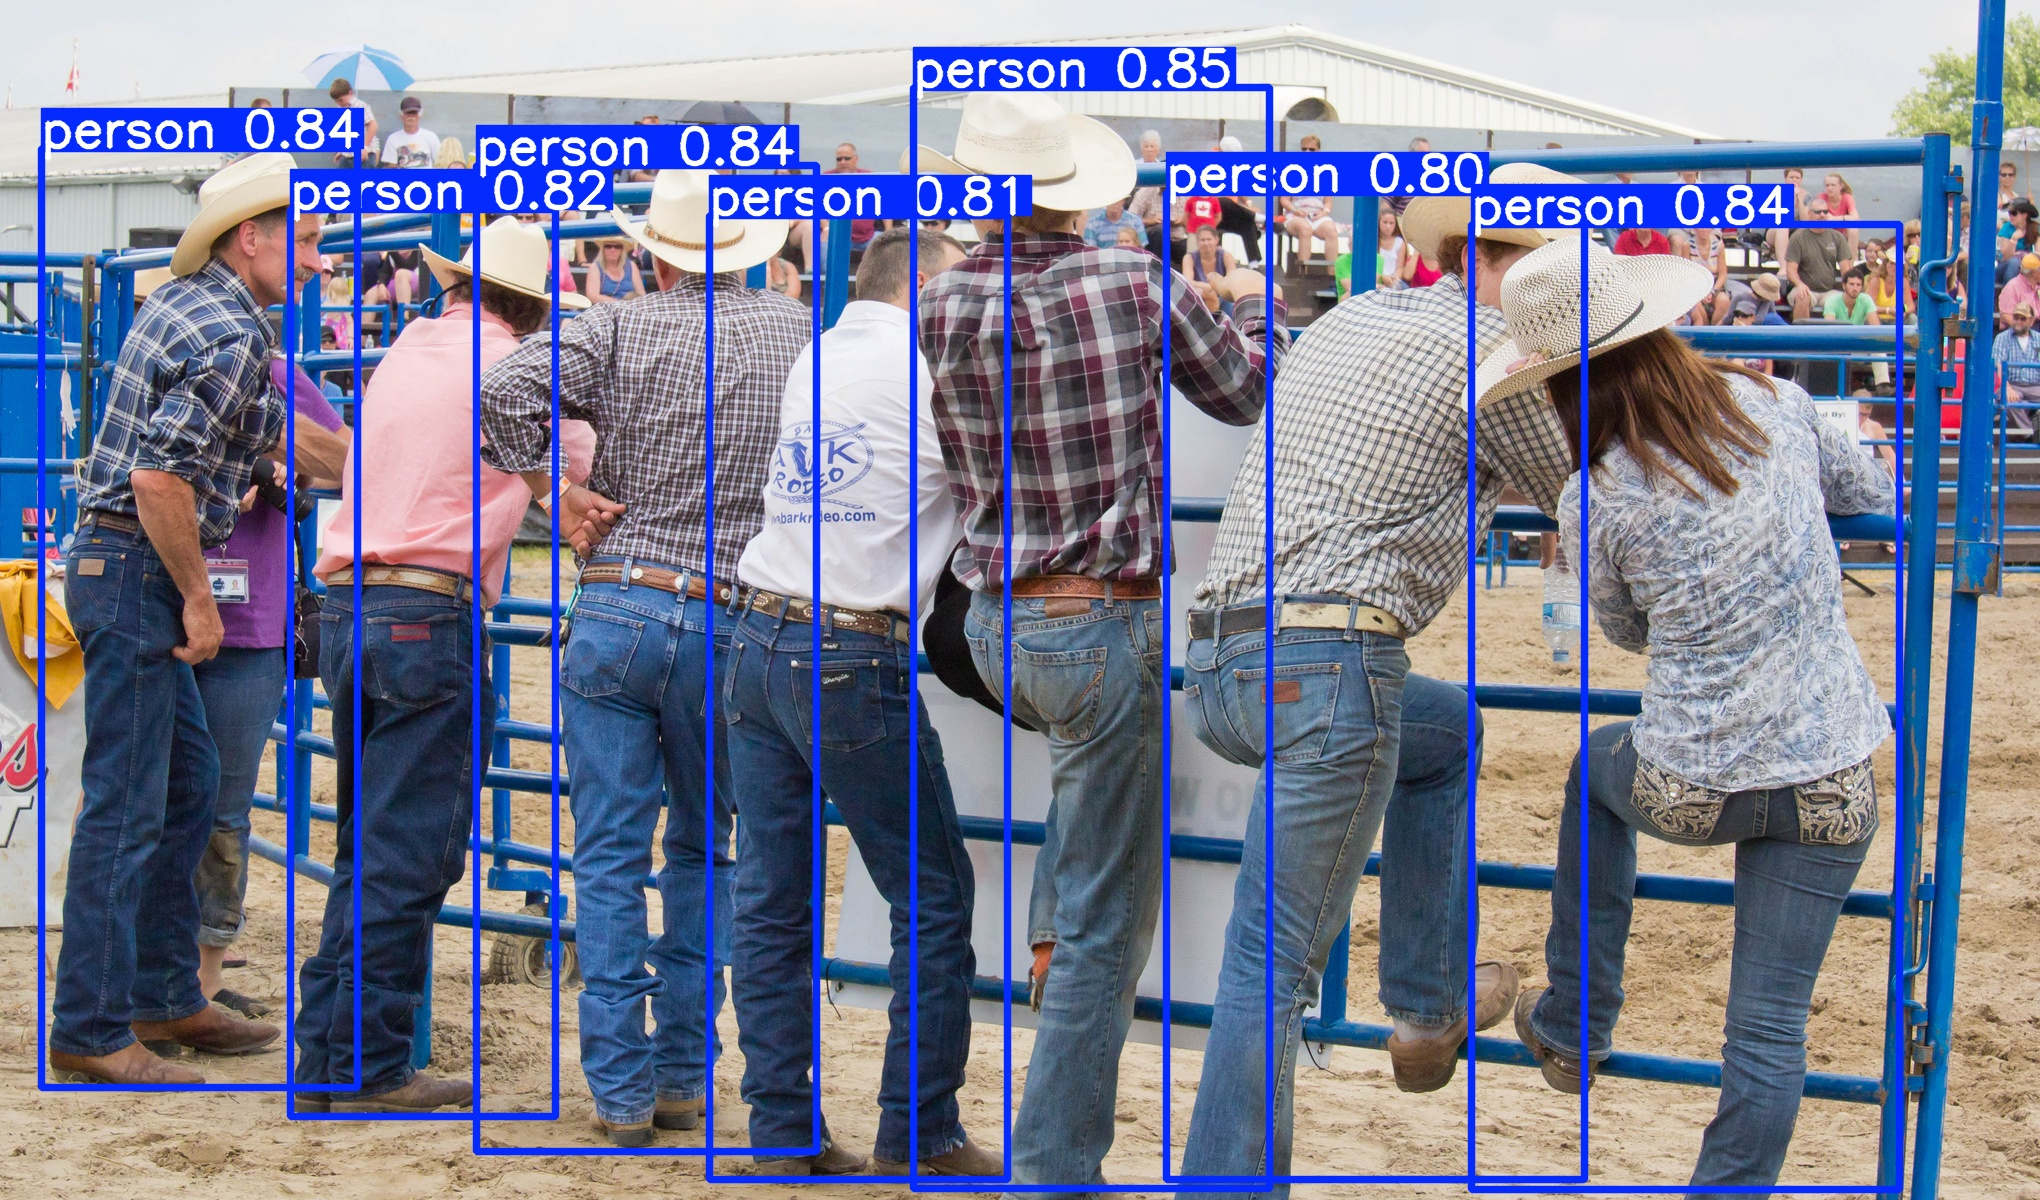

In [8]:
Image(filename='/content/runs/detect/predict/img_4_gt.jpg', height=600)

In [10]:
model = YOLO('/content/yolov8n.pt')
results = model.predict(source='/content/img_4_gt.png', conf=0.1)


image 1/1 /content/img_4_gt.png: 384x640 13 persons, 1 umbrella, 1 bottle, 1 cup, 168.6ms
Speed: 4.6ms preprocess, 168.6ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


In [11]:
results

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted p

In [12]:
for result in results:
    boxes = result.boxes

bbox=boxes.xyxy.tolist()[0]

bbox

[913.0384521484375, 87.92200469970703, 1269.67041015625, 1188.6826171875]

In [13]:
sam_checkpoint = "/content/sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
predictor = SamPredictor(sam)

In [14]:
image = cv2.cvtColor(cv2.imread('/content/img_4_gt.png'), cv2.COLOR_BGR2RGB)
predictor.set_image(image)

In [15]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

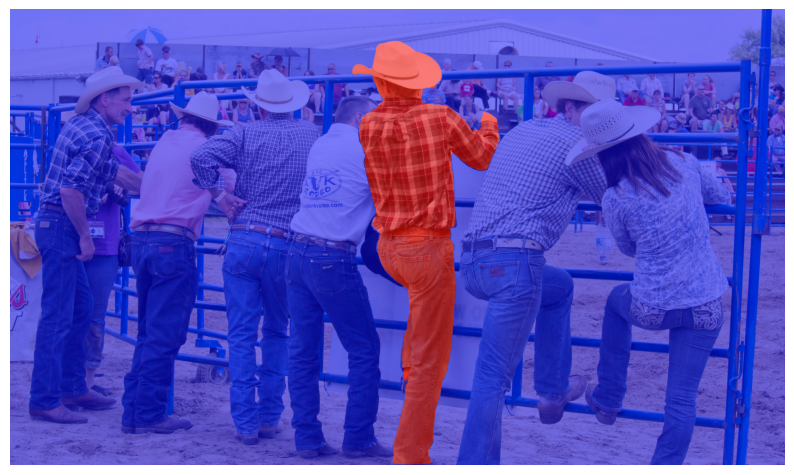

In [24]:
# Input bounding box
input_box = np.array(bbox)

# Get mask predictions
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

# Get the first mask
mask = masks[0]

# Create colored masks for mask and non-mask areas
mask_color = np.array([255, 0, 0], dtype=np.uint8)  # Red for the mask
non_mask_color = np.array([0, 0, 255], dtype=np.uint8)  # Blue for the non-mask

# Create a 3-channel mask image
colored_mask = np.zeros_like(image)

# Apply mask color to the mask region
colored_mask[mask] = mask_color

# Apply non-mask color to the background
colored_mask[~mask] = non_mask_color

# Blend the original image and the mask with transparency
alpha = 0.5  # Transparency level
output_image = cv2.addWeighted(image, 1 - alpha, colored_mask, alpha, 0)

# Plot the result
plt.figure(figsize=(10, 10))
plt.imshow(output_image)
plt.axis('off')
plt.show()


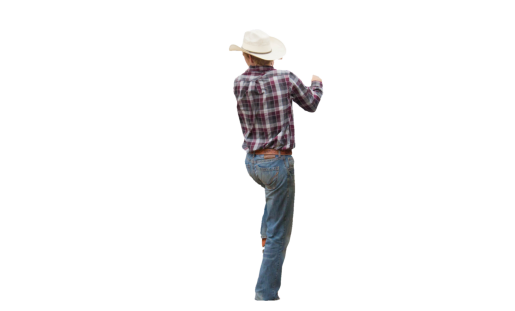

In [17]:
segmentation_mask = masks[0]
binary_mask = np.where(segmentation_mask > 0.5, 1, 0)

white_background = np.ones_like(image) * 255

new_image = white_background * (1 - binary_mask[..., np.newaxis]) + image * binary_mask[..., np.newaxis]

plt.imshow(new_image.astype(np.uint8))
plt.axis('off')
plt.show()


image 1/1 /content/img_4_gt.png: 384x640 8 persons, 144.8ms
Speed: 2.9ms preprocess, 144.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


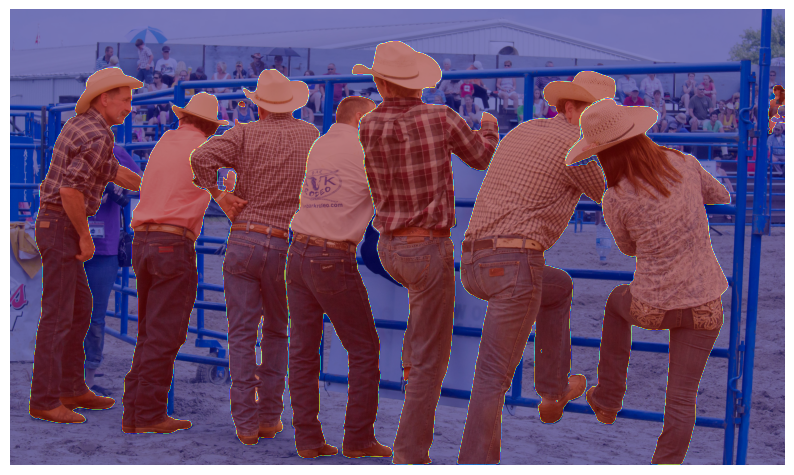

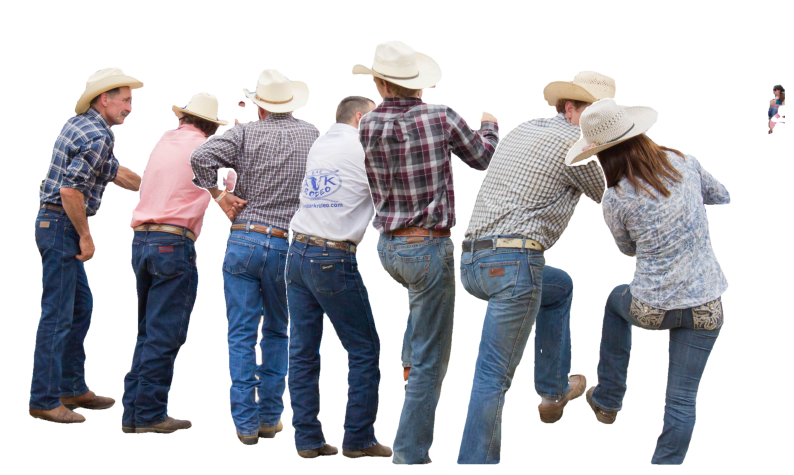

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image_path = '/content/img_4_gt.png'

# Predict all objects in the image
results = model.predict(source=image_path, conf=0.2)

# Load and preprocess the image
image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
predictor.set_image(image)

# Initialize an empty mask for combining all individual masks
combined_mask = np.zeros(image.shape[:2], dtype=np.uint8)

# Loop through each detected object
for result in results:
    boxes = result.boxes

    for box in boxes.xyxy.tolist():
        input_box = np.array(box)

        masks, _, _ = predictor.predict(
            point_coords=None,
            point_labels=None,
            box=input_box[None, :],
            multimask_output=False,
        )

        segmentation_mask = masks[0]
        binary_mask = np.where(segmentation_mask > 0.5, 1, 0)

        # Combine the individual mask with the combined mask
        combined_mask = np.maximum(combined_mask, binary_mask)

# Create the segmented image with a white background for non-mask regions
white_background = np.ones_like(image) * 255
new_image = white_background * (1 - combined_mask[..., np.newaxis]) + image * combined_mask[..., np.newaxis]

# Display the combined mask and segmented image
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.imshow(combined_mask, alpha=0.5, cmap='jet')
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 10))
plt.imshow(new_image.astype(np.uint8))
plt.axis('off')
plt.show()